Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Create an ExactGP on a representative subset (2500 samples) of the data

(2600, 37) (2600,)


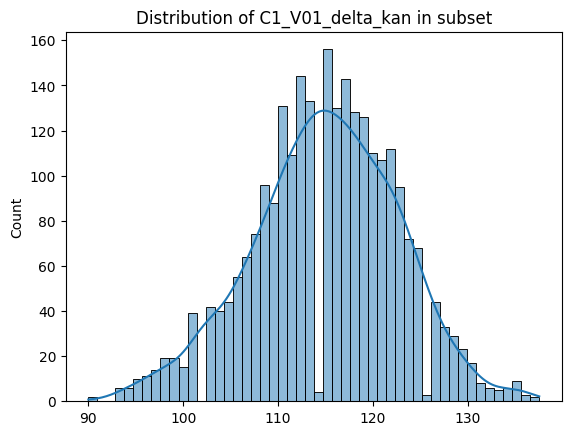

(1560, 37) (520, 37) (520, 37)
Feature names after preprocessing:
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import data_prep

# check the computer name to determine the path to the data
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
    
df = pd.read_excel(path)

target = 'C1_V01_delta_kan'

x_data = df.drop(columns=[target])
y_data = df[target].to_numpy()

subset_x, x_rest, y_subset, y_rest = train_test_split(
    x_data, y_data, test_size=0.95, random_state=42)

print(subset_x.shape, y_subset.shape)

sns.histplot(y_subset, bins=50, kde =True)
plt.title('Distribution of C1_V01_delta_kan in subset')
plt.show()

X_temp, X_test, y_temp, y_test = train_test_split(subset_x, y_subset, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# use custom function "cat_transform" to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = data_prep.cat_transform(X_train, X_val, X_test, ['BT_NR', 'STP_NR'])
# print(X_train_prep.columns)

    # pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
    ])

# get the feature names after preprocessing for the feature importance
feature_names = X_train.columns

print("Feature names after preprocessing:")
print(feature_names)

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train)
X_val = data_pipeline.transform(X_val)
X_test = data_pipeline.transform(X_test)

In [3]:
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
    
print(type(X_train_tensor), X_train_tensor.shape)

torch.Size([1560, 37]) torch.Size([520, 37]) torch.Size([520, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
<class 'torch.Tensor'> torch.Size([1560, 37])


In [3]:
import gpytorch
import torch.distributions as dist

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:



# initialize likelihood and model
exact_GP_likelihood = gpytorch.likelihoods.GaussianLikelihood()
exact_GP_model = ExactGPModel(X_train_tensor, y_train_tensor, exact_GP_likelihood)

y_mean = y_train_tensor.mean().item()
exact_GP_model.mean_module.initialize(constant=y_mean)  # Initialize the mean to the mean of the training targets

y_var = y_train_tensor.var().item()
exact_GP_model.covar_module.outputscale = y_var  # Initialize the outputscale to the variance of the training targets

training_iter = 200

# Find optimal model hyperparameters
if torch.cuda.is_available():
    exact_GP_model = exact_GP_model.cuda()
    exact_GP_likelihood = exact_GP_likelihood.cuda()

# Use the adam optimizer
optimizer = torch.optim.Adam(exact_GP_model.parameters(), lr=0.05)  

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_GP_likelihood, exact_GP_model)

best_val_r2 = -np.inf
patience = 10
counter = 0

for i in range(training_iter):
    exact_GP_model.train()
    exact_GP_likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = exact_GP_model(X_train_tensor)
    
    # Calc loss and backprop gradients
    
    loss = -mll(output, y_train_tensor)
    loss.backward()   
    
    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()
    
        # Evaluate model and likelihood
    exact_GP_model.eval()
    exact_GP_likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = exact_GP_model(X_val_tensor)
        val_preds = exact_GP_likelihood(f_val_preds)
        
        val_mean = val_preds.mean
        val_std= val_preds.stddev
        val_dist = dist.Normal(loc=val_mean, scale=val_std)
        val_nll = -val_preds.log_prob(y_val_tensor).mean().item()
        #print(val_nll)
        r2_score_val = r2_score(y_val, val_mean)
        
        print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        if r2_score_val > best_val_r2:
            best_val_r2 = r2_score_val
            best_model_state = exact_GP_model.state_dict()
            best_likelihood_state = exact_GP_likelihood.state_dict()
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f'Early stopping at iteration {i + 1} with best validation R²: {best_val_r2:.3f}')
            exact_GP_model.load_state_dict(best_model_state)
            exact_GP_likelihood.load_state_dict(best_likelihood_state)
            break
        
        

Iter 1/200 - Loss: 3.209
Validation NLL: 1583.4969482421875 R²: 0.467
Iter 2/200 - Loss: 3.199
Validation NLL: 1574.800048828125 R²: 0.485
Iter 3/200 - Loss: 3.187
Validation NLL: 1566.7020263671875 R²: 0.503
Iter 4/200 - Loss: 3.178
Validation NLL: 1560.8935546875 R²: 0.519
Iter 5/200 - Loss: 3.160
Validation NLL: 1556.33056640625 R²: 0.534
Iter 6/200 - Loss: 3.153
Validation NLL: 1555.6458740234375 R²: 0.548
Iter 7/200 - Loss: 3.132
Validation NLL: 1553.24853515625 R²: 0.561
Iter 8/200 - Loss: 3.122
Validation NLL: 1546.2684326171875 R²: 0.572
Iter 9/200 - Loss: 3.115
Validation NLL: 1547.5274658203125 R²: 0.582
Iter 10/200 - Loss: 3.106
Validation NLL: 1543.1051025390625 R²: 0.592
Iter 11/200 - Loss: 3.090
Validation NLL: 1546.44970703125 R²: 0.600
Iter 12/200 - Loss: 3.085
Validation NLL: 1543.8721923828125 R²: 0.607
Iter 13/200 - Loss: 3.072
Validation NLL: 1552.7706298828125 R²: 0.614
Iter 14/200 - Loss: 3.069
Validation NLL: 1560.1336669921875 R²: 0.619
Iter 15/200 - Loss: 3.052

In [10]:
# print the final model parameters and lengthscale and noise
print("Final model parameters:")
print(f"Mean: {exact_GP_model.mean_module.constant.item()}")
print(f"Outputscale: {exact_GP_model.covar_module.outputscale.item()}")
print(f"Lengthscale: {exact_GP_model.covar_module.base_kernel.lengthscale}")
print(f"Noise: {exact_GP_likelihood.noise.item()}")

Final model parameters:
Mean: 113.50688934326172
Outputscale: 51.27014923095703
Lengthscale: tensor([[0.6931, 4.8214, 2.5822, 1.2143, 1.8636, 1.6235, 1.0237, 1.3453, 3.1186,
         2.6688, 4.9789, 2.7767, 1.1867, 1.7473, 2.0611, 1.7159, 1.0018, 2.6874,
         1.7224, 4.5550, 2.2345, 3.1041, 0.6589, 2.8884, 6.7956, 6.7325, 5.8664,
         6.5682, 0.9197, 1.7639, 4.0025, 6.7147, 0.2799, 6.5405, 4.6537, 4.9045,
         0.5569]], grad_fn=<SoftplusBackward0>)
Noise: 5.217484951019287


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Train Data: 0.952
R² on Validation Data: 0.776
R² on Test Data: 0.805
Number of true values within the confidence interval: 496 out of 520
Coverage: 95.38%


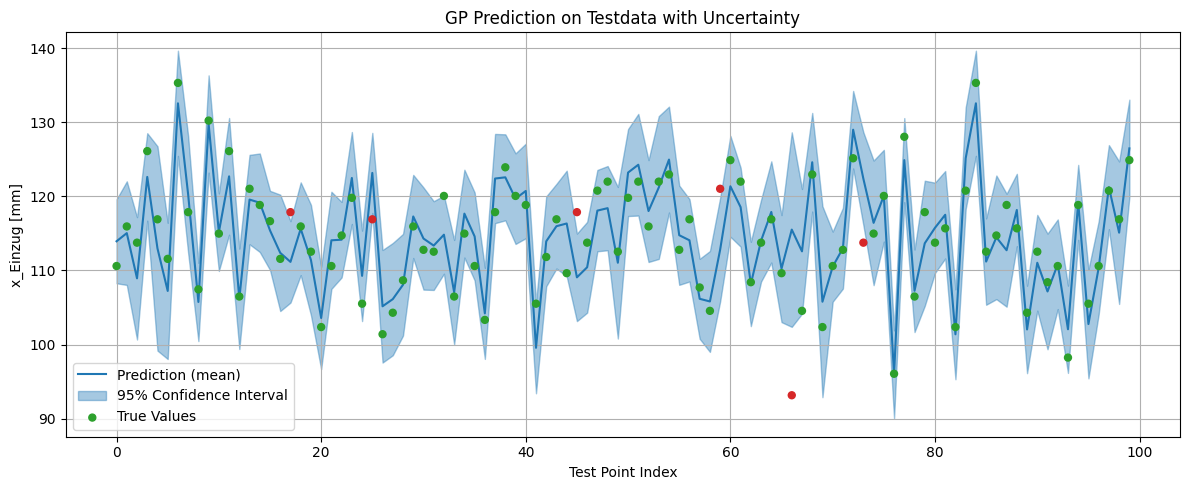

In [11]:
# Switch model and likelihood to evaluation mode
exact_GP_model.eval()
exact_GP_likelihood.eval()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = exact_GP_model(X_train_tensor)            # Latent function predictions
    y_preds = exact_GP_likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")

with torch.no_grad():
    f_preds_val = exact_GP_model(X_val_tensor)            # Latent function predictions
    y_preds_val = exact_GP_likelihood(f_preds_val)        # Observed predictions with noise
    
val_eman = y_preds_val.mean.numpy()

r2_val = r2_score(y_val, val_eman)
print(f"R² on Validation Data: {r2_val:.3f}")

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = exact_GP_model(X_test_tensor)            # Latent function predictions
    y_preds = exact_GP_likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.numpy()
test_stddev = y_preds.stddev.numpy()

# Calculate R² for the test data
r2_test = r2_score(y_test, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

CI_counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        CI_counter += 1

print(f"Number of true values within the confidence interval: {CI_counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, test_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Speichern
torch.save({
    'model_state_dict': exact_GP_model.state_dict(),
    'likelihood_state_dict': exact_GP_likelihood.state_dict()
}, "Modelsaves/exact_GP1.pth")

In [6]:
checkpoint = torch.load("Modelsaves/exact_GP1.pth")

exact_GP_model = ExactGPModel(X_train_tensor, y_train_tensor, gpytorch.likelihoods.GaussianLikelihood())
exact_GP_likelihood = gpytorch.likelihoods.GaussianLikelihood()

exact_GP_model.load_state_dict(checkpoint['model_state_dict'])
exact_GP_likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

C:\Users\test\AppData\Local\Temp\ipykernel_19348\579836358.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("Modelsaves/exact_GP1.pth")


<All keys matched successfully>

In [7]:
lengthscale = exact_GP_model.covar_module.base_kernel.lengthscale.detach().cpu()
outputscale = exact_GP_model.covar_module.outputscale.detach().cpu()
noise = exact_GP_likelihood.noise.detach().cpu()

print(f"Lengthscale: {lengthscale}")
print(f"Outputscale: {outputscale}")
print(f"Noise: {noise}")

Lengthscale: tensor([[0.6931, 4.8214, 2.5822, 1.2143, 1.8636, 1.6235, 1.0237, 1.3453, 3.1186,
         2.6688, 4.9789, 2.7767, 1.1867, 1.7473, 2.0611, 1.7159, 1.0018, 2.6874,
         1.7224, 4.5550, 2.2345, 3.1041, 0.6589, 2.8884, 6.7956, 6.7325, 5.8664,
         6.5682, 0.9197, 1.7639, 4.0025, 6.7147, 0.2799, 6.5405, 4.6537, 4.9045,
         0.5569]])
Outputscale: 51.27014923095703
Noise: tensor([5.2175])


Transformation Pipeline

In [5]:
import data_prep

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float() # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Stochastic Variational GP Regression Implementation

Natural Gradient Descent with Variational Models for better and faster convergence

In [25]:
import gpytorch
from gpytorch.models import ApproximateGP


#create a TensorDataset and DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module  = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))
        
        
        #self.mean_module.initialize(constant=y_train_tensor.mean().item())  # Initialize the mean to the mean of the training targets
        self.covar_module.base_kernel.lengthscale = lengthscale
        self.covar_module.outputscale = outputscale  # Initialize the outputscale to the variance of the training targets
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Define the inducing points
# Randomly select 500 inducing points from the training data
num_inducing_points = 1500
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

print(inducing_points.shape)
print(inducing_points)

model = GPModel(inducing_points = inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise

print(model)
print(model.mean_module.constant.item())
print(model.covar_module.base_kernel.lengthscale)
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

torch.Size([1500, 37])
tensor([[-0.0354,  0.8450,  0.6694,  ...,  0.7666,  0.1377,  1.0920],
        [-0.0354,  0.8913,  0.0337,  ..., -0.6977, -0.0546,  1.0759],
        [-0.0354,  0.8450, -1.1064,  ..., -0.6977, -1.2125, -0.0840],
        ...,
        [-0.0354, -0.7937,  0.4565,  ...,  2.2310, -0.1493, -1.4999],
        [-0.0354,  0.8450, -0.2772,  ...,  0.7666, -0.6365,  1.0335],
        [-0.0354, -0.5916,  0.4762,  ...,  0.7666, -0.0317,  1.0335]])
GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
0.0
tensor([[0.6931, 4.8214, 2.5822, 1.2143, 1.8636, 1.6235, 1.0237, 1.3453, 3.1186,
         2.6688, 4.9789, 2.7767, 1.1867, 1.7473, 2.0611, 1.7159, 1.0018, 2.6874,
         1.7224, 4.5550, 2.2345, 3.1041, 0.6589, 2.888

In [26]:
num_epochs = 250

model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.05)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.02)

# VariationalELBO is used for training
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

best_val_r2 = -np.inf
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    likelihood.train()
    for x_batch, y_batch in train_loader:
        # Zero gradients from previous iteration        
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        # Print the loss for every tenth batch
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

        epoch_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch
          
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = model(X_val_tensor)
        val_preds = likelihood(f_val_preds)
        
        val_mean = val_preds.mean.cpu().numpy()
        val_std = val_preds.stddev.cpu().numpy()
        val_nll = -val_preds.log_prob(y_val_tensor).mean().item()
        #print(val_nll)
        r2_score_val = r2_score(y_val, val_mean)
        
        print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        if r2_score_val > best_val_r2:
            best_val_r2 = r2_score_val
            best_model_state = model.state_dict()
            best_likelihood_state = likelihood.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at iteration {epoch + 1} with best validation R²: {best_val_r2:.3f}')
            model.load_state_dict(best_model_state)
            likelihood.load_state_dict(best_likelihood_state)
            break

Epoch 1/250, Loss: 49.4921
Validation NLL: 31595.591796875 R²: 0.348
Epoch 2/250, Loss: 4.7775
Validation NLL: 30160.83984375 R²: 0.483
Epoch 3/250, Loss: 4.3621
Validation NLL: 29632.615234375 R²: 0.524
Epoch 4/250, Loss: 4.1156
Validation NLL: 29084.724609375 R²: 0.565
Epoch 5/250, Loss: 3.9891
Validation NLL: 28856.759765625 R²: 0.589
Epoch 6/250, Loss: 3.8575
Validation NLL: 28586.052734375 R²: 0.608
Epoch 7/250, Loss: 3.8039
Validation NLL: 28436.970703125 R²: 0.626
Epoch 8/250, Loss: 3.7259
Validation NLL: 28392.412109375 R²: 0.636
Epoch 9/250, Loss: 3.6947
Validation NLL: 28121.951171875 R²: 0.655
Epoch 10/250, Loss: 3.6337
Validation NLL: 28134.71484375 R²: 0.657
Epoch 11/250, Loss: 3.5930
Validation NLL: 28036.099609375 R²: 0.676
Epoch 12/250, Loss: 3.5405
Validation NLL: 27855.337890625 R²: 0.684
Epoch 13/250, Loss: 3.5255
Validation NLL: 27818.521484375 R²: 0.692
Epoch 14/250, Loss: 3.4960
Validation NLL: 27628.798828125 R²: 0.709
Epoch 15/250, Loss: 3.4684
Validation NLL: 2

In [27]:
print(model)
print(model.mean_module.constant.item())
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)
print(likelihood.noise.item())


GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
0.7450737357139587
tensor([[ 4.1155, 15.5167,  5.0016,  4.0690,  5.6475,  5.9149,  3.2303,  4.4628,
          6.6810,  5.4430, 10.1225,  4.0128,  2.3883,  3.3273,  3.7850,  2.4722,
          2.2049,  5.2991,  2.4595,  4.8428,  5.4108,  4.3302,  1.4425,  3.0918,
          6.4037,  7.9008, 10.1805,  7.8193,  2.2693,  3.3247, 10.2165,  9.1114,
          1.6605,  7.0481, 13.4951, 14.2526,  0.9789]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)
tensor(51.4364, device='cuda:0', grad_fn=<SoftplusBackward0>)
6.422734260559082


Make Predictions

In [32]:
model.eval()
likelihood.eval()
means = []
variances = []
stddevs = []
with torch.no_grad():
    # Make predictions on the test set

    preds = likelihood(model(X_test_tensor))
    
    # Mean:
    means.append(preds.mean.cpu())
    
    # Variance
    variances.append(preds.variance.cpu())
    
    # Standard Deviation
    stddevs.append(preds.stddev.cpu())

means = torch.cat(means)
variances = torch.cat(variances)
stddevs = torch.cat(stddevs)  

# check type of means, variances, stddevs
print(type(means), type(variances), type(stddevs))
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Standard Deviations shape:", stddevs.shape)


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Means shape: torch.Size([10403])
Variances shape: torch.Size([10403])
Standard Deviations shape: torch.Size([10403])


R² on Train Data: 0.841
R² on Test Data: 0.803
Number of true values within the confidence interval: 9527 out of 10403
Coverage: 91.58%


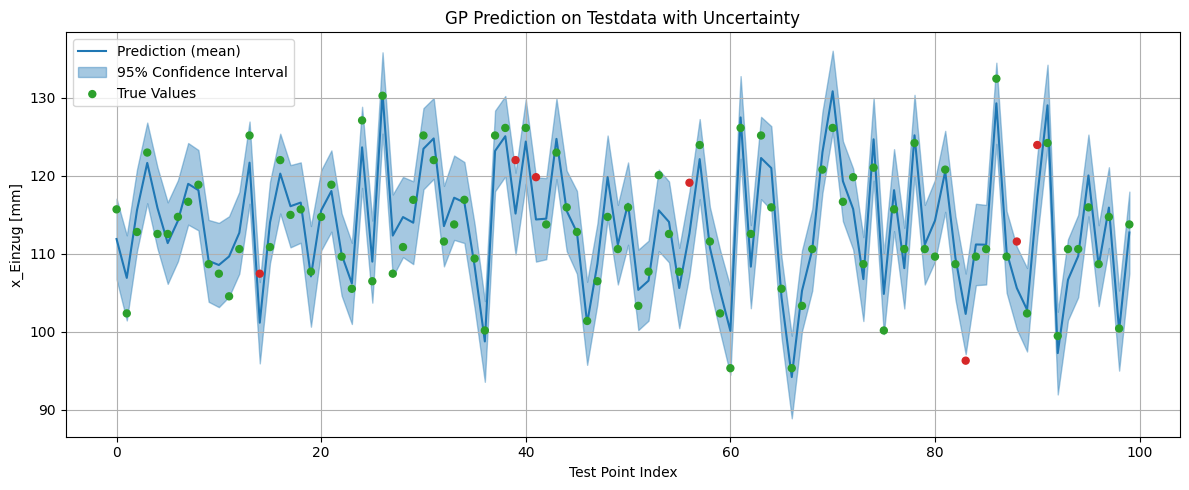

In [33]:
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train_tensor)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.cpu().numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")


means = means.numpy()
stddevs = stddevs.numpy()
# Calculate R² for the test data
r2_test = r2_score(y_test, means)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = means - 2*stddevs
gp_upper = means + 2*stddevs

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, means[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Exact GP Model Definition and Training

In [6]:
import gpytorch


# Define an Exact GP Model using a constant mean and an RBF (Radial Basis Function) kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())  # RBF kernel scaled by a learnable factor

    def forward(self, X):
        mean_x = self.mean_module(X)           # Compute the mean of the GP
        covar_x = self.covar_module(X)         # Compute the covariance (kernel)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the GP model with training data and likelihood
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood)

# Set model and likelihood into training mode
model.train()
likelihood.train()

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()
# Use Adam optimizer to train kernel and likelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal log likelihood is used as the loss function for GP training
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Number of training iterations
training_iter = 1

# Training loop
for i in range(training_iter):
    optimizer.zero_grad()              # Reset gradients
    output = model(X_train_tensor)               # Forward pass
    loss = -mll(output, y_train_tensor)          # Negative marginal log likelihood (to minimize)
    loss.backward()                    # Backpropagation

    # Print progress every 10 iterations
    if i % 1 == 0:
        print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
              'squared lengthscale: ',
              f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
              f'noise variance: {model.likelihood.noise.item(): .3f}')

    optimizer.step()                   # Update parameters

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3896505984 bytes.

Manual Grid Search for GP

Data Plotting

c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
Coverage: 100.00%


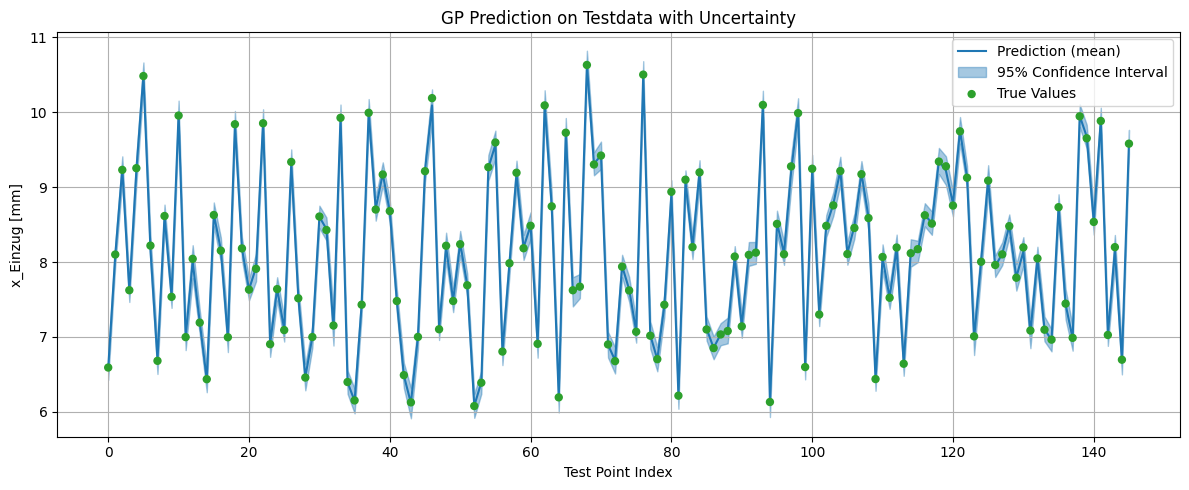

In [ ]:
# Switch model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train.numpy(), train_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = model(X_test)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.numpy()
test_stddev = y_preds.stddev.numpy()

# Calculate R² for the test data
r2_test = r2_score(y_test.numpy(), test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test.numpy() >= gp_lower) & (y_test.numpy() <= gp_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(len(X_test))

# Plot predicted mean
plt.plot(x_axis, test_mean, label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower, gp_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test.numpy(), label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training mit Cross Validation

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle = True, random_state= 42)

X = torch.from_numpy(data_prep).float()
y = torch.from_numpy(data_labels).float()

# Number of training iterations
training_iter = 100

for train_idx, test_idx in kf.split(data_prep):
  X_tr, X_te = X[train_idx], X[test_idx]
  y_tr, y_te = y[train_idx], y[test_idx]

  # Define the Gaussian likelihood
  likelihood = gpytorch.likelihoods.GaussianLikelihood()

  # Initialize the GP model with training data and likelihood
  model = ExactGPModel(X_tr, y_tr, likelihood)

  # Set model and likelihood into training mode
  model.train()
  likelihood.train()

  # Use Adam optimizer to train kernel and likelihood parameters
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

  # Marginal log likelihood is used as the loss function for GP training
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  # Training loop
  for i in range(training_iter):
      optimizer.zero_grad()              # Reset gradients
      output = model(X_tr)               # Forward pass
      loss = -mll(output, y_tr)          # Negative marginal log likelihood (to minimize)
      loss.backward()                    # Backpropagation

      # Print progress every 10 iterations
      if i % 10 == 0:
          print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
                'squared lengthscale: ',
                f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
                f'noise variance: {model.likelihood.noise.item(): .3f}')

      optimizer.step()                   # Update parameters

  # Switch model and likelihood to evaluation mode
  model.eval()
  likelihood.eval()

  # Predictive distribution for train data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_tr)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  train_mean = y_preds.mean.numpy()
 
  # Calculate R² for the train data
  r2_test = r2_score(y_tr.numpy(), train_mean)
  print(f"R² on Train Data: {r2_test:.3f}")

  # Predictive distribution for test data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_te)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  test_mean = y_preds.mean.numpy()
 
  # Calculate R² for the test data
  r2_test = r2_score(y_te.numpy(), test_mean)
  print(f"R² on Test Data: {r2_test:.3f}")

 Iter 1/100 - Loss:  11.669 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.540 squared lengthscale:   1.526 noise variance:  1.052
 Iter 31/100 - Loss:  1.287 squared lengthscale:   1.715 noise variance:  0.823
 Iter 41/100 - Loss:  1.050 squared lengthscale:   1.832 noise variance:  0.530
 Iter 51/100 - Loss:  0.771 squared lengthscale:   1.919 noise variance:  0.284
 Iter 61/100 - Loss:  0.453 squared lengthscale:   2.001 noise variance:  0.130
 Iter 71/100 - Loss:  0.115 squared lengthscale:   2.091 noise variance:  0.054
 Iter 81/100 - Loss: -0.224 squared lengthscale:   2.195 noise variance:  0.022
 Iter 91/100 - Loss: -0.559 squared lengthscale:   2.318 noise variance:  0.009
R² on Train Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.626 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.539 squared lengthscale:   1.527 noise variance:  1.052
 Iter 31/100 - Loss:  1.286 squared lengthscale:   1.716 noise variance:  0.821
 Iter 41/100 - Loss:  1.048 squared lengthscale:   1.834 noise variance:  0.529
 Iter 51/100 - Loss:  0.768 squared lengthscale:   1.922 noise variance:  0.282
 Iter 61/100 - Loss:  0.449 squared lengthscale:   2.004 noise variance:  0.129
 Iter 71/100 - Loss:  0.111 squared lengthscale:   2.094 noise variance:  0.054
 Iter 81/100 - Loss: -0.230 squared lengthscale:   2.199 noise variance:  0.022
 Iter 91/100 - Loss: -0.565 squared lengthscale:   2.322 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


 Iter 1/100 - Loss:  11.619 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.065
 Iter 21/100 - Loss:  1.537 squared lengthscale:   1.527 noise variance:  1.049
 Iter 31/100 - Loss:  1.283 squared lengthscale:   1.716 noise variance:  0.817
 Iter 41/100 - Loss:  1.043 squared lengthscale:   1.833 noise variance:  0.524
 Iter 51/100 - Loss:  0.762 squared lengthscale:   1.921 noise variance:  0.279
 Iter 61/100 - Loss:  0.442 squared lengthscale:   2.003 noise variance:  0.127
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.093 noise variance:  0.053
 Iter 81/100 - Loss: -0.238 squared lengthscale:   2.198 noise variance:  0.022
 Iter 91/100 - Loss: -0.573 squared lengthscale:   2.322 noise variance:  0.009


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Train Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.697 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.063
 Iter 21/100 - Loss:  1.536 squared lengthscale:   1.527 noise variance:  1.046
 Iter 31/100 - Loss:  1.282 squared lengthscale:   1.715 noise variance:  0.814
 Iter 41/100 - Loss:  1.042 squared lengthscale:   1.832 noise variance:  0.521
 Iter 51/100 - Loss:  0.761 squared lengthscale:   1.919 noise variance:  0.277
 Iter 61/100 - Loss:  0.440 squared lengthscale:   2.001 noise variance:  0.126
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.090 noise variance:  0.053
 Iter 81/100 - Loss: -0.236 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.569 squared lengthscale:   2.319 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


 Iter 1/100 - Loss:  11.586 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.183 squared lengthscale:   1.196 noise variance:  1.063
 Iter 21/100 - Loss:  1.531 squared lengthscale:   1.525 noise variance:  1.044
 Iter 31/100 - Loss:  1.276 squared lengthscale:   1.713 noise variance:  0.808
 Iter 41/100 - Loss:  1.034 squared lengthscale:   1.829 noise variance:  0.514
 Iter 51/100 - Loss:  0.750 squared lengthscale:   1.917 noise variance:  0.271
 Iter 61/100 - Loss:  0.427 squared lengthscale:   1.999 noise variance:  0.122
 Iter 71/100 - Loss:  0.087 squared lengthscale:   2.089 noise variance:  0.051
 Iter 81/100 - Loss: -0.254 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.589 squared lengthscale:   2.319 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 0.999


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
